In [161]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay


In [162]:
df = pd.read_json("loan_approval_dataset.json")

df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [163]:
df = df.set_index("Id")

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252000 entries, 1 to 252000
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Income             252000 non-null  int64 
 1   Age                252000 non-null  int64 
 2   Experience         252000 non-null  int64 
 3   Married/Single     252000 non-null  object
 4   House_Ownership    252000 non-null  object
 5   Car_Ownership      252000 non-null  object
 6   Profession         252000 non-null  object
 7   CITY               252000 non-null  object
 8   STATE              252000 non-null  object
 9   CURRENT_JOB_YRS    252000 non-null  int64 
 10  CURRENT_HOUSE_YRS  252000 non-null  int64 
 11  Risk_Flag          252000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 25.0+ MB


In [165]:
df.isna().sum()

Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

The dataset contains no missing values

In [166]:
df.columns

Index(['Income', 'Age', 'Experience', 'Married/Single', 'House_Ownership',
       'Car_Ownership', 'Profession', 'CITY', 'STATE', 'CURRENT_JOB_YRS',
       'CURRENT_HOUSE_YRS', 'Risk_Flag'],
      dtype='object')

In [167]:
df.describe(include='number')

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


Observationns

There are 252,000 observations in the dataset for each feature.

Income has the highest average value around 4.997 million, followed by Age around 49.95 years.

Experience, CURRENT_JOB_YRS, and CURRENT_HOUSE_YRS all have an average around 10-12 years.

The standard deviation is highest for Income, indicating a wider spread of values compared to other features.

The minimum value for Income is much lower than the average, suggesting potential outliers or skewed data.


In [168]:
df.describe(include='object')

,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE
count,252000,252000,252000,252000,252000,252000
unique,2,3,2,51,317,29
top,single,rented,no,Physician,Vijayanagaram,Uttar_Pradesh
freq,226272,231898,176000,5957,1259,28400


Observations

More applicants are single than married .

There are more renters than homeowners, and more applicants without cars than with cars.

The top profession is Physcian, majority of the applicant reside in  Uttar_Pradesh  state and Vijayanagaram city

In [169]:
df["Risk_Flag"].value_counts()

Risk_Flag
0    221004
1     30996
Name: count, dtype: int64

The label has high class imbalance

In [170]:
cat_col = ["Married/Single", "House_Ownership", "Car_Ownership", "Profession", "CITY", "STATE"]

In [171]:
for col in df[cat_col]:
    print(df[col].value_counts())
    print(" ")
    print("**" * 20)
    

Married/Single
single     226272
married     25728
Name: count, dtype: int64
 
****************************************
House_Ownership
rented          231898
owned            12918
norent_noown      7184
Name: count, dtype: int64
 
****************************************
Car_Ownership
no     176000
yes     76000
Name: count, dtype: int64
 
****************************************
Profession
Physician                     5957
Statistician                  5806
Web_designer                  5397
Psychologist                  5390
Computer_hardware_engineer    5372
Drafter                       5359
Magistrate                    5357
Fashion_Designer              5304
Air_traffic_controller        5281
Comedian                      5259
Industrial_Engineer           5250
Mechanical_engineer           5217
Chemical_engineer             5205
Technical_writer              5195
Hotel_Manager                 5178
Financial_Analyst             5167
Graphic_Designer              5166
Flight_at

Exploratory Data Analysis

In [172]:
#Setting Custom colors
my_colors = ["#ff6e54", "#ffa600", "#ff2e63", "#9378ff", "#56e39f", "#ff67ab",
"#d0e6e3", "#7fd4b3", "#f8b886", "#ffc107", "#4169e1", "#2ecc71"]

# Create a seaborn palette object
my_palette = sns.color_palette(my_colors)

# Use the custom palette with a seaborn function
sns.set_palette(my_palette)

from matplotlib.colors import ListedColormap
colors = ['#ffc3a0', "#2ecc71", "#9378ff", "#ffa600"]
my_cmap = sns.color_palette(colors)
cmap = ListedColormap(colors)

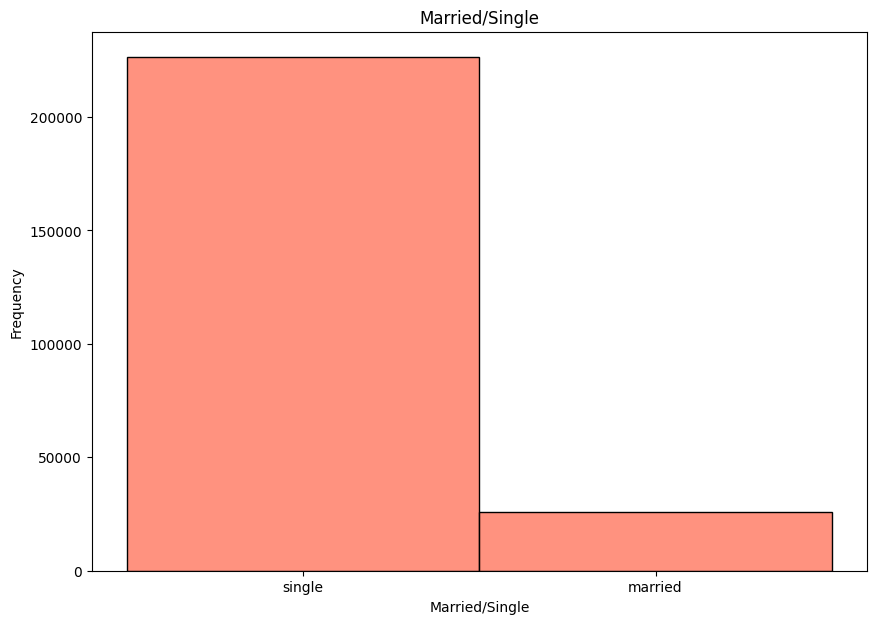

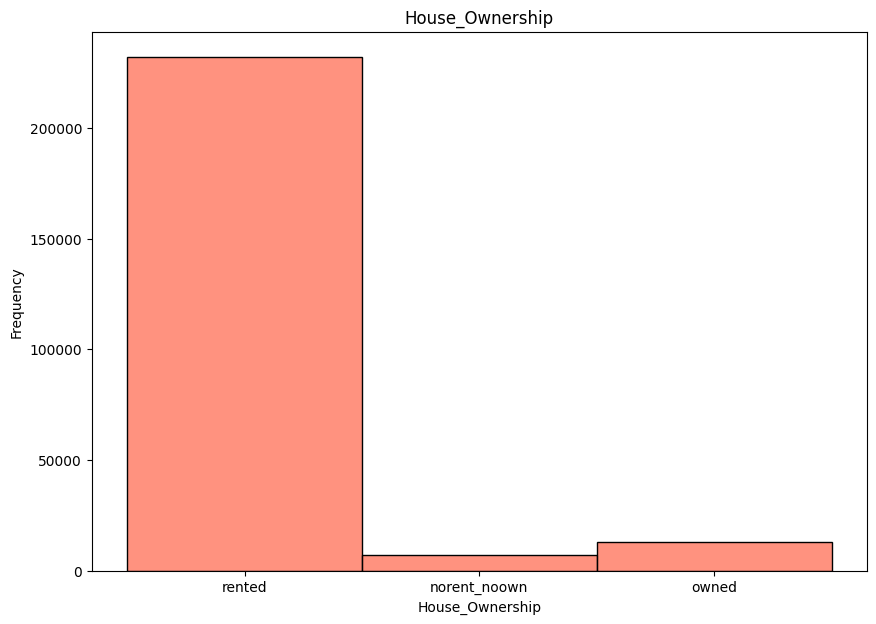

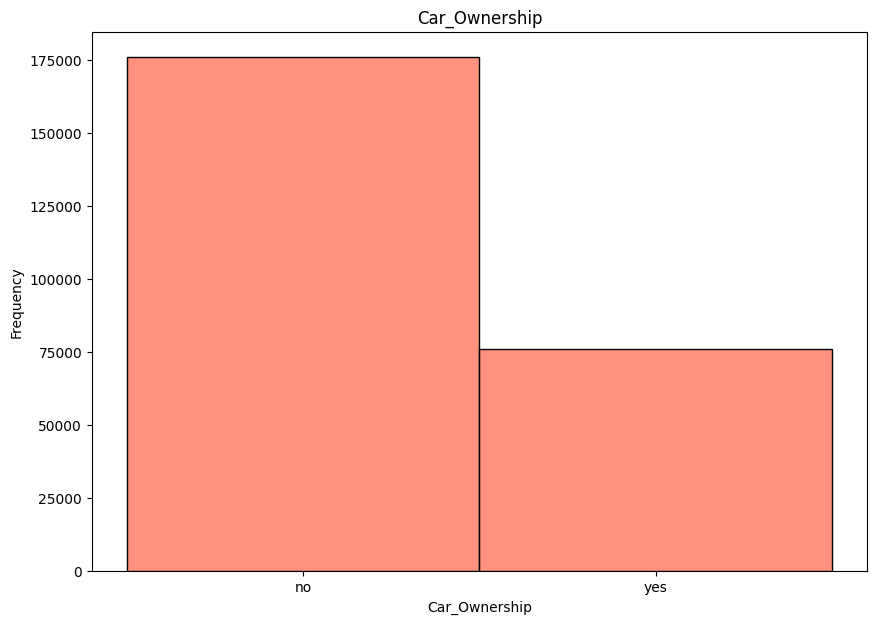

In [173]:
for i in ["Married/Single", "House_Ownership", "Car_Ownership"]:
    plt.figure(figsize=(10, 7))
    plt.title(i)
    sns.histplot(df[i]).set(ylabel='Frequency')
    plt.show();

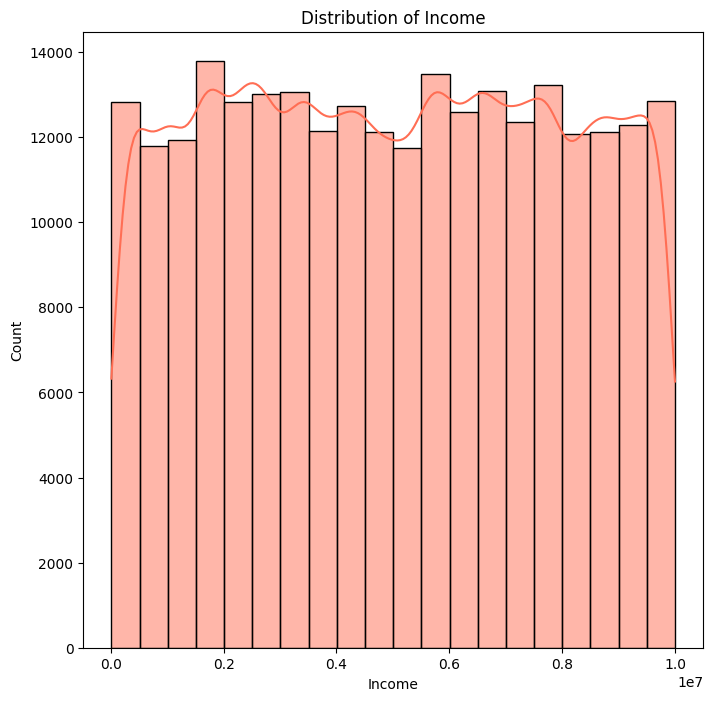

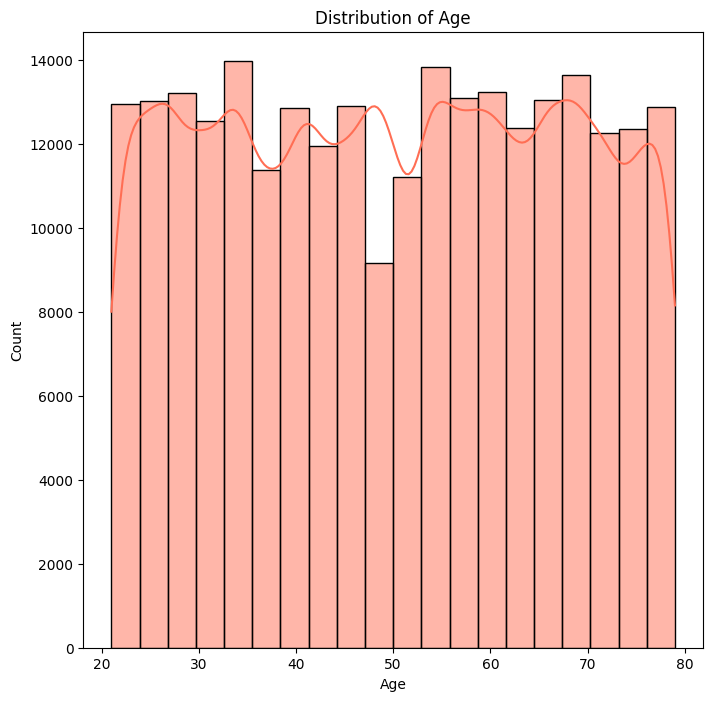

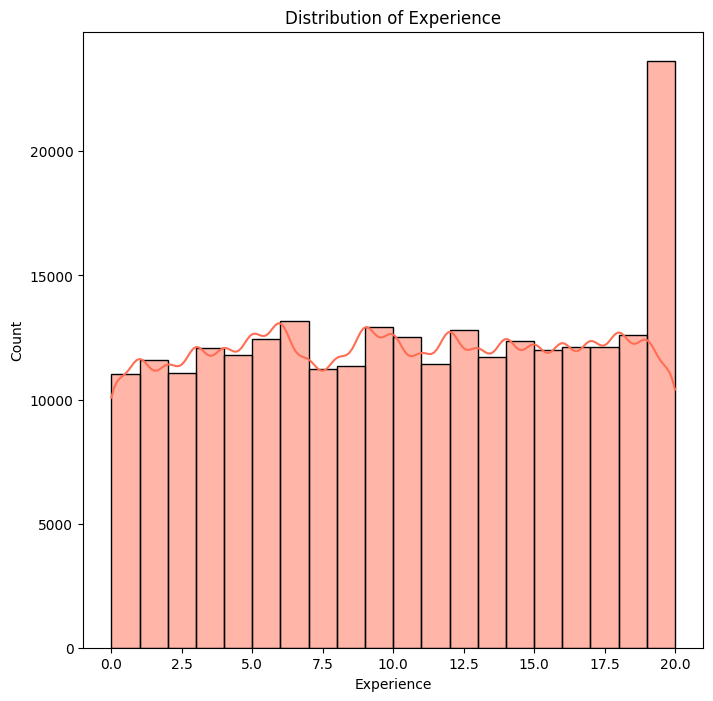

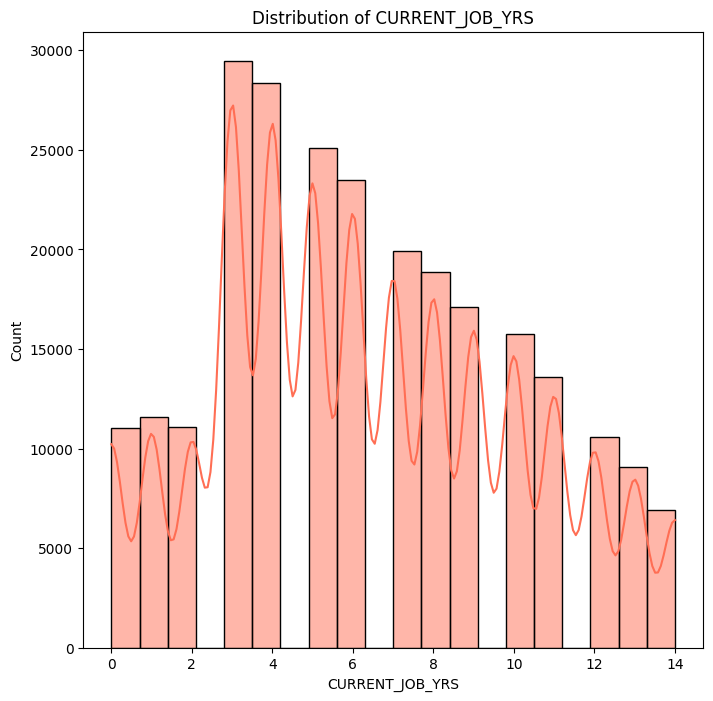

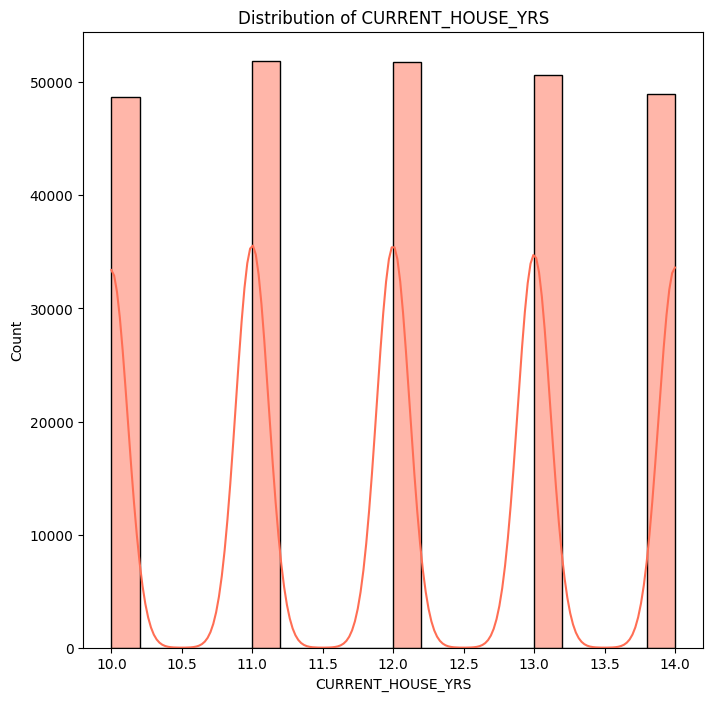

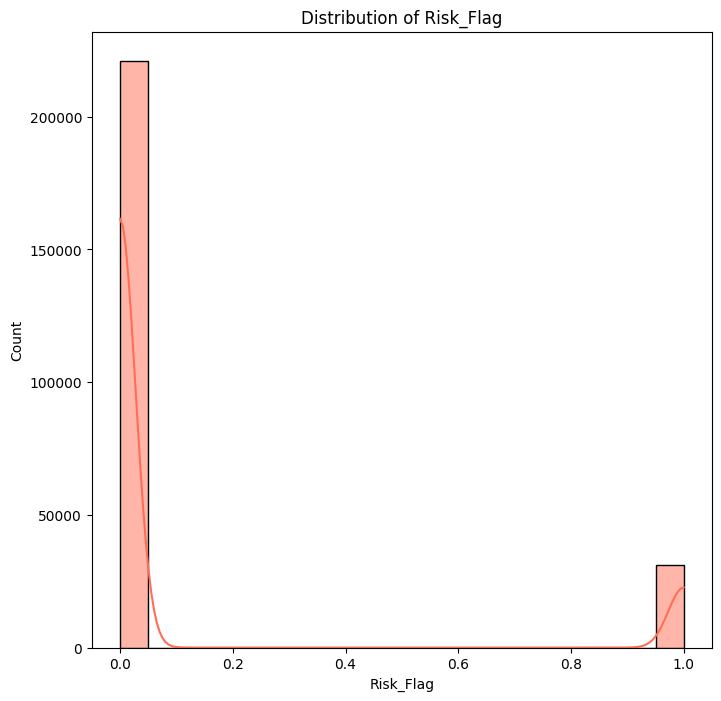

In [174]:
for i in ['Income', 'Age', 'Experience','CURRENT_JOB_YRS',
       'CURRENT_HOUSE_YRS', 'Risk_Flag']:
    plt.figure(figsize=(8, 8))
    sns.histplot(df[i], bins=20, kde=True)
    plt.title('Distribution of {}'.format(i))
    plt.show();

<Figure size 1000x600 with 0 Axes>

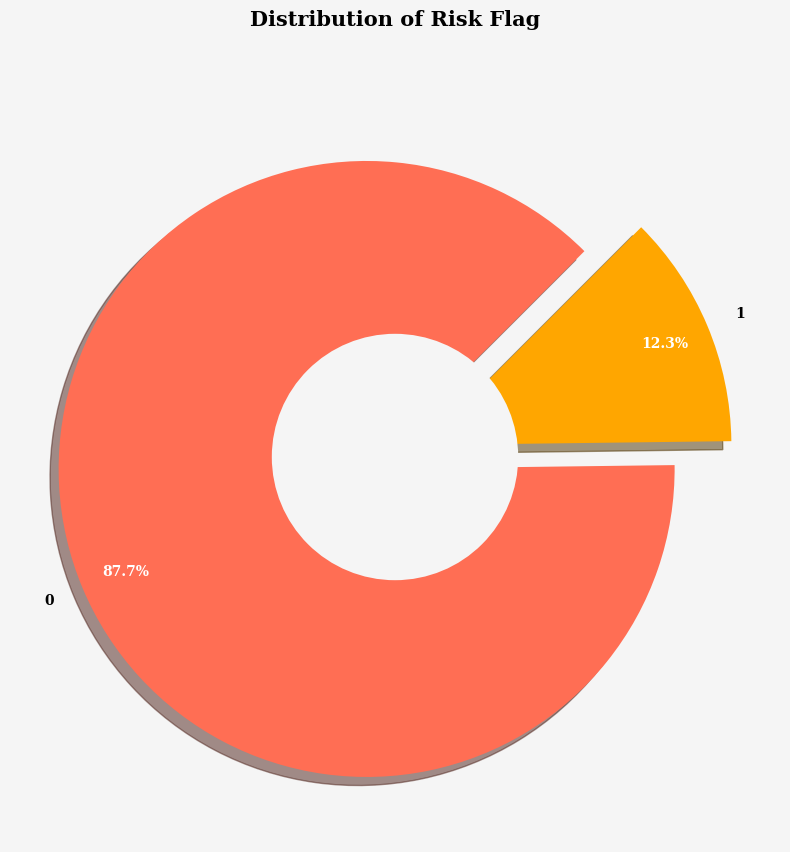

In [175]:
plt.figure(figsize=(10,6))
label_data = df['Risk_Flag'].value_counts()
explode = [0.1] * 2
plt.figure(figsize=(20, 10), facecolor='#F5F5F5') # background color
patches, texts, pcts = plt.pie(label_data,
                            labels=label_data.index,
                            pctdistance=0.85,
                            shadow=True,
                            startangle=45,
                            explode=explode,
                            autopct='%1.1f%%',
                            textprops={'fontsize': 10,
                                        'color': 'black',
                                        'weight': 'bold',
                                        'family': 'serif'}
                              );
plt.setp(pcts, color='white')
hfont = {'fontname': 'serif', 'weight': 'bold'}
plt.title('Distribution of Risk Flag', size=15, **hfont, y=1.05)
centre_circle = plt.Circle((0, 0), 0.40, fc='#F5F5F5') # circle's color
fig = plt.gcf()
fig.gca().add_artist(centre_circle);

<Figure size 1000x600 with 0 Axes>

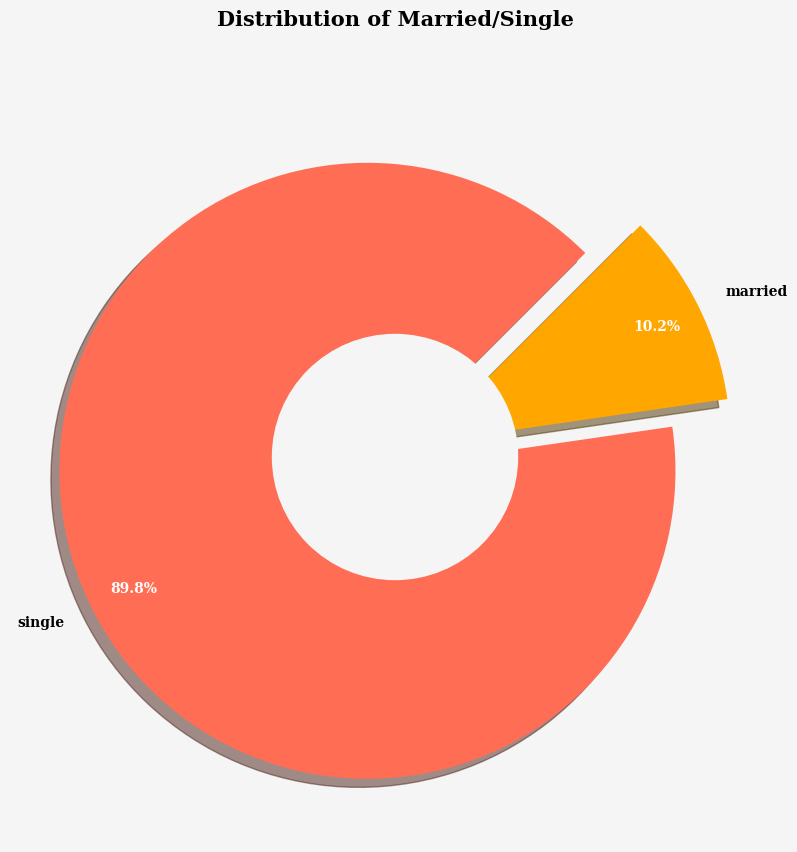

In [176]:
plt.figure(figsize=(10,6))
label_data = df["Married/Single"].value_counts()
explode = [0.1] * 2
plt.figure(figsize=(20, 10), facecolor='#F5F5F5') # background color
patches, texts, pcts = plt.pie(label_data,
                            labels=label_data.index,
                            pctdistance=0.85,
                            shadow=True,
                            startangle=45,
                            explode=explode,
                            autopct='%1.1f%%',
                            textprops={'fontsize': 10,
                                        'color': 'black',
                                        'weight': 'bold',
                                        'family': 'serif'}
                              );
plt.setp(pcts, color='white')
hfont = {'fontname': 'serif', 'weight': 'bold'}
plt.title('Distribution of Married/Single', size=15, **hfont, y=1.05)
centre_circle = plt.Circle((0, 0), 0.40, fc='#F5F5F5') # circle's color
fig = plt.gcf()
fig.gca().add_artist(centre_circle);

89.8 percent applicants are single while 10.2 percent are married

C:\Users\User\AppData\Local\Temp\ipykernel_9472\1325439102.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['Profession'], palette=colors)
C:\Users\User\AppData\Local\Temp\ipykernel_9472\1325439102.py:3: UserWarning: 
The palette list has fewer values (6) than needed (51) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(x=df['Profession'], palette=colors)


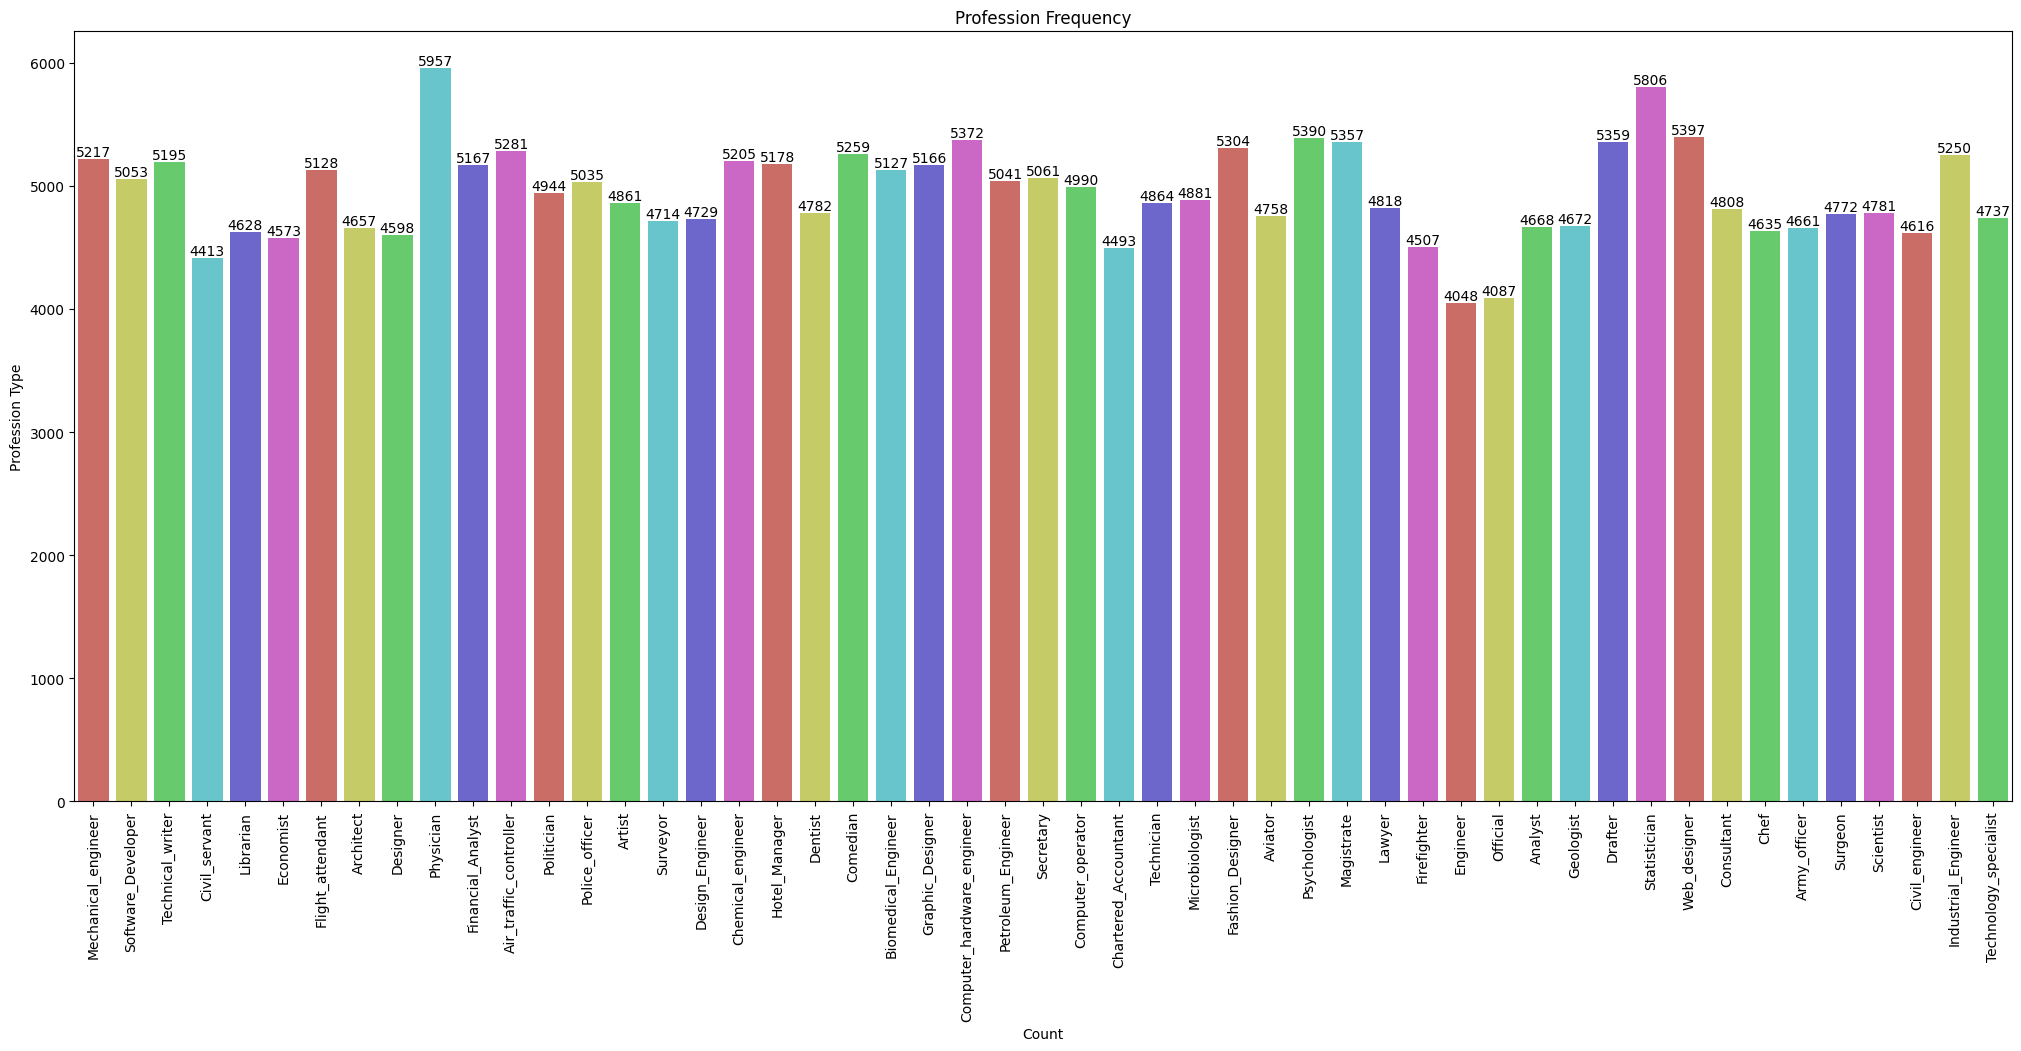

In [177]:
colors = sns.color_palette("hls")
plt.figure(figsize=(25, 10))
ax = sns.countplot(x=df['Profession'], palette=colors)

plt.title("Profession Frequency")
plt.ylabel("Profession Type")
plt.xlabel("Count")
plt.xticks(rotation=90)

for container in ax.containers:
    ax.bar_label(container)
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_9472\2370757011.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['STATE'],  palette=my_palette)
C:\Users\User\AppData\Local\Temp\ipykernel_9472\2370757011.py:2: UserWarning: 
The palette list has fewer values (12) than needed (29) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(x=df['STATE'],  palette=my_palette)


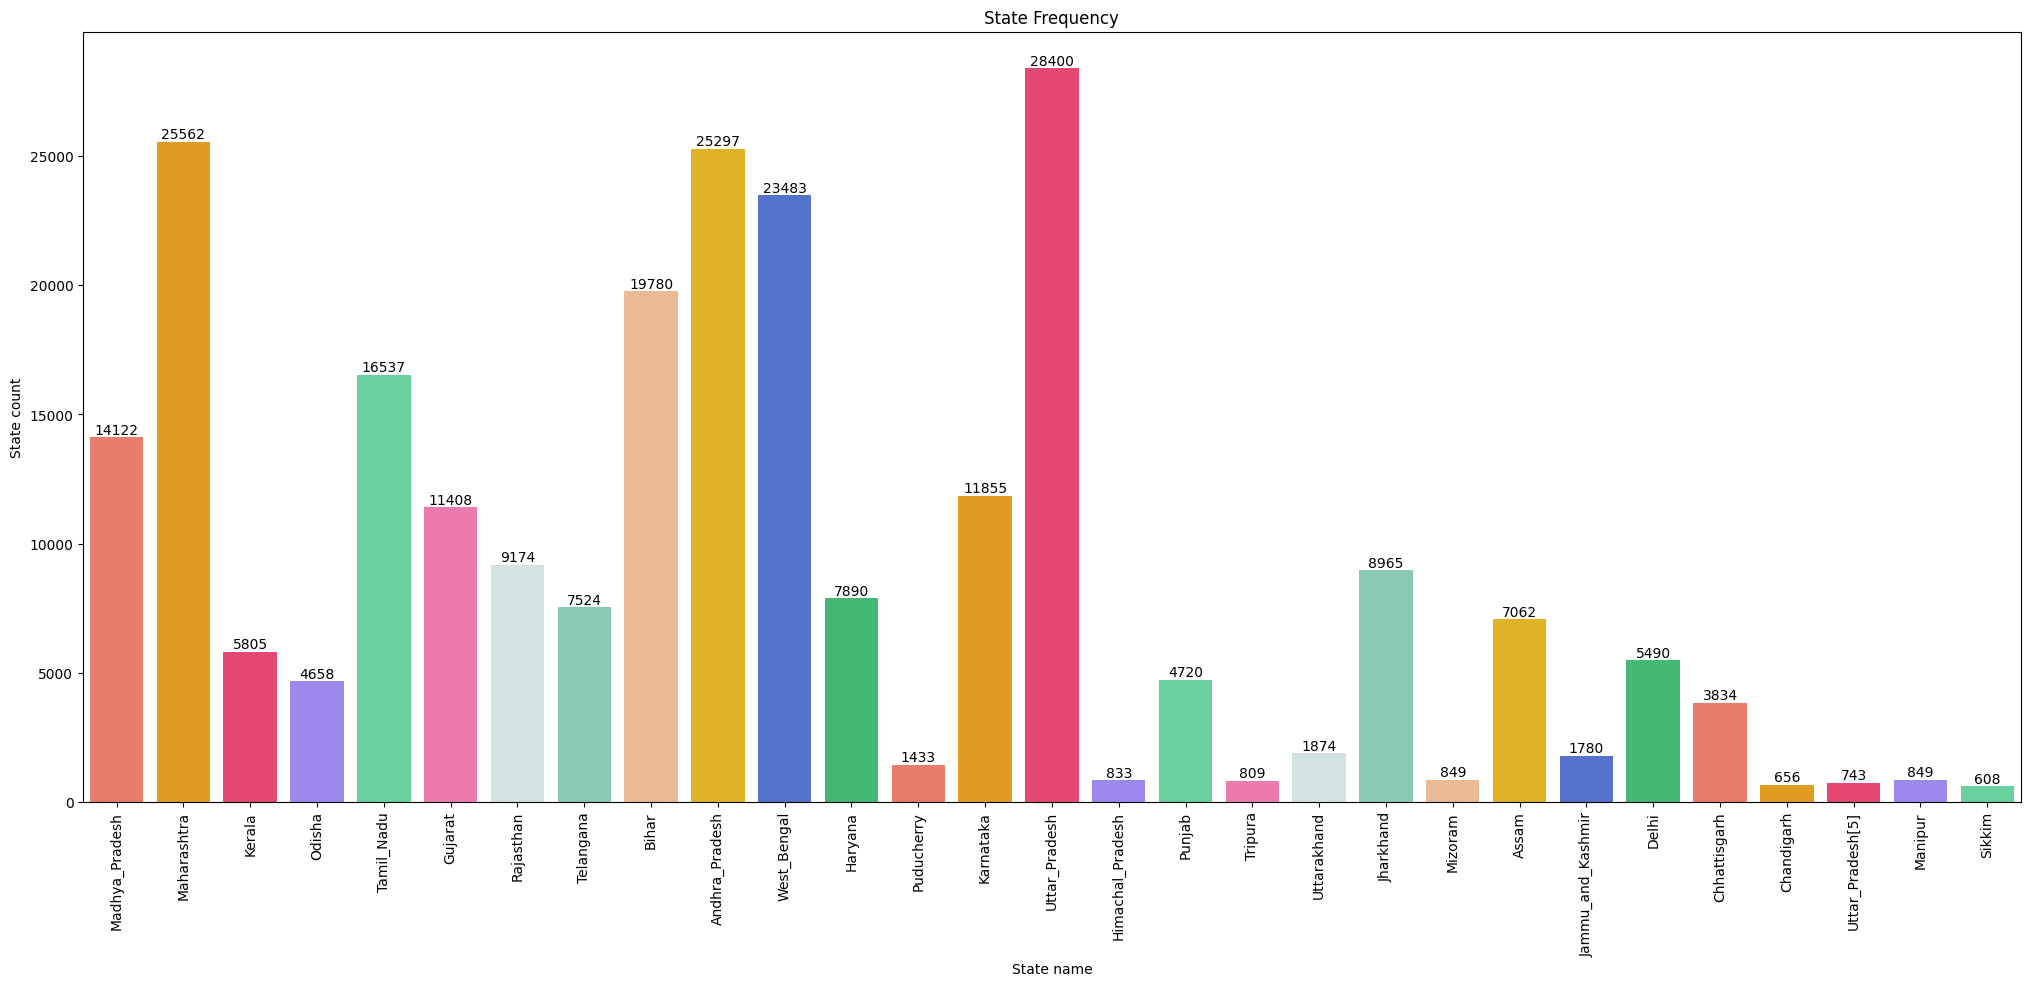

In [178]:
plt.figure(figsize=(25, 10))
ax = sns.countplot(x=df['STATE'],  palette=my_palette)

plt.title("State Frequency")
plt.ylabel("State count")
plt.xlabel("State name")
plt.xticks(rotation=90)

for container in ax.containers:
    ax.bar_label(container)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_9472\2358907441.py:2: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  ax = sns.countplot(x=df['Married/Single'], hue=df['Risk_Flag'],  palette=my_palette)


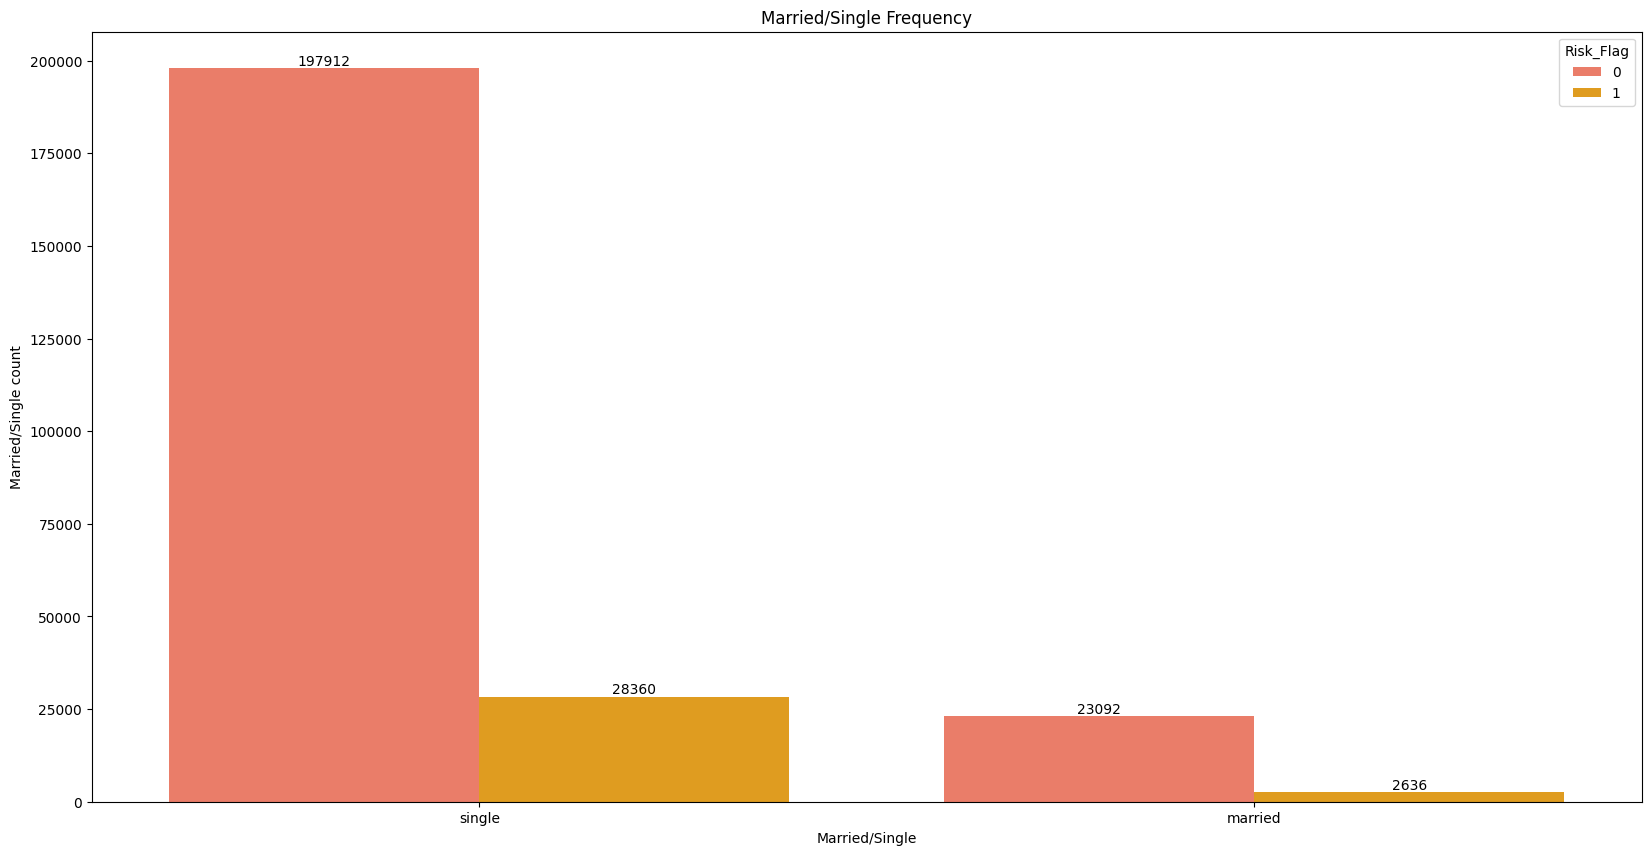

In [179]:
plt.figure(figsize=(20, 10))
ax = sns.countplot(x=df['Married/Single'], hue=df['Risk_Flag'],  palette=my_palette)

plt.title("Married/Single Frequency")
plt.ylabel("Married/Single count")
plt.xlabel("Married/Single")

for container in ax.containers:
    ax.bar_label(container)
plt.show()

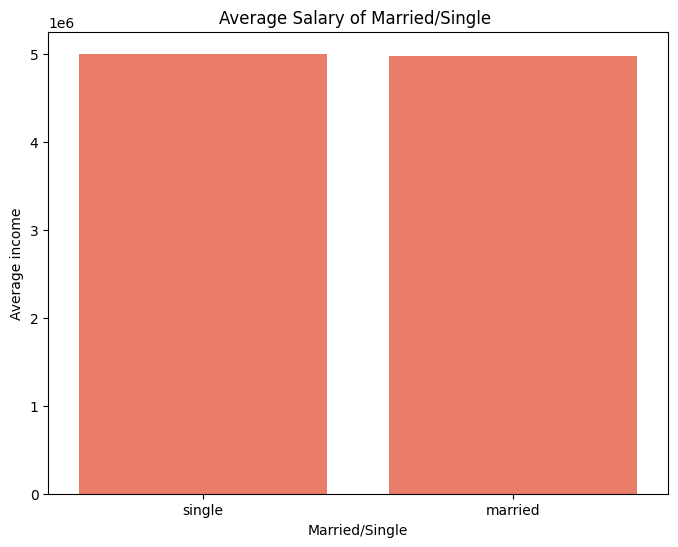

In [180]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x=df['Married/Single'],
    y=df['Income'], 
    errorbar=None
)

plt.title("Average Salary of Married/Single ")
plt.ylabel("Average income")
plt.xlabel("Married/Single");



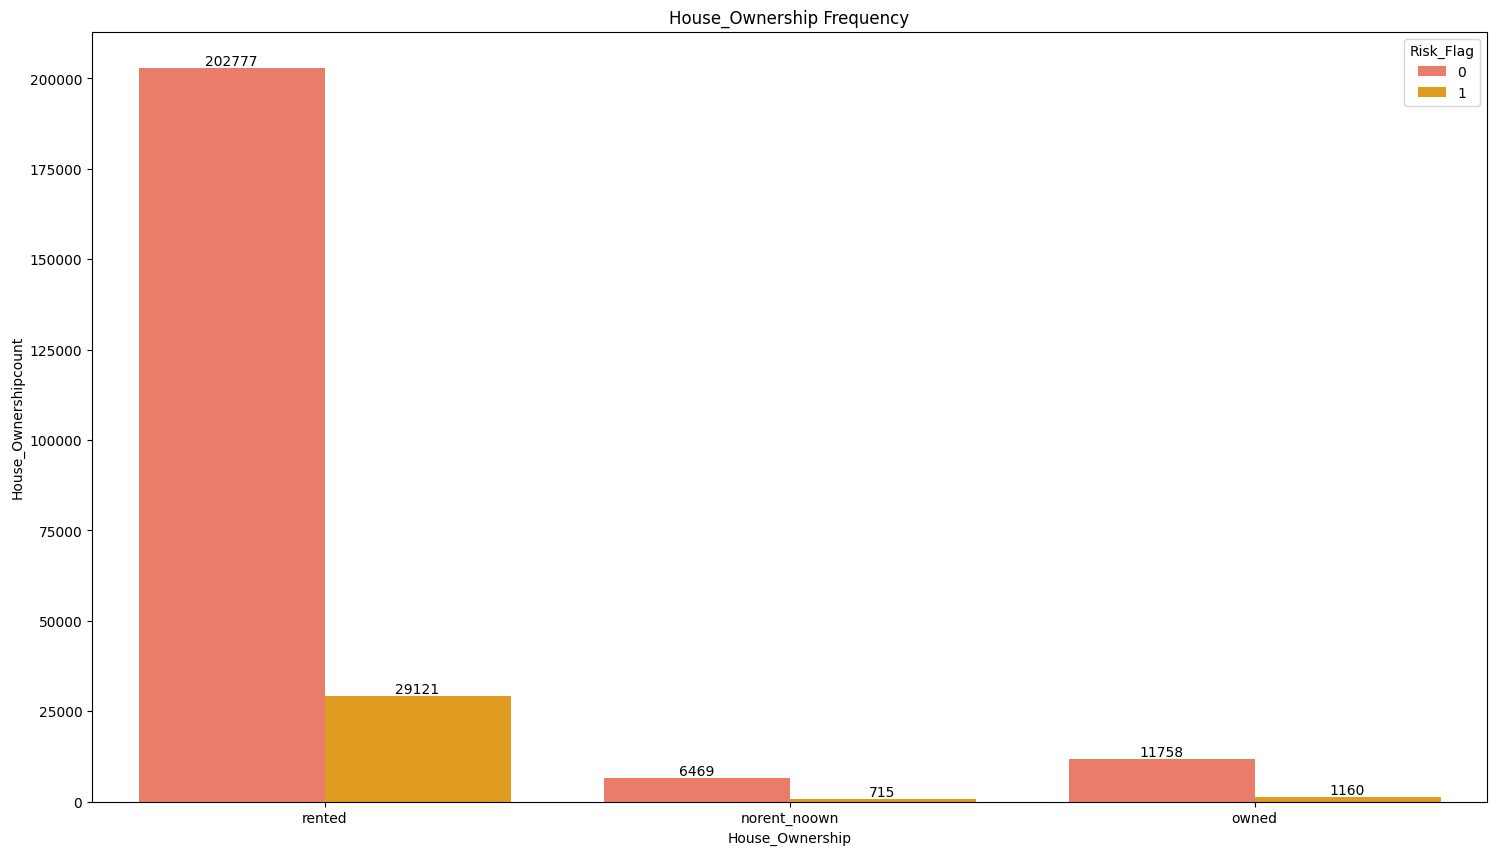

In [181]:
plt.figure(figsize=(18, 10))
ax = sns.countplot(
    x="House_Ownership", 
    hue='Risk_Flag', 
    data=df
)

plt.title("House_Ownership Frequency")
plt.ylabel("House_Ownershipcount")
plt.xlabel("House_Ownership")

for container in ax.containers:
    ax.bar_label(container)
plt.show()

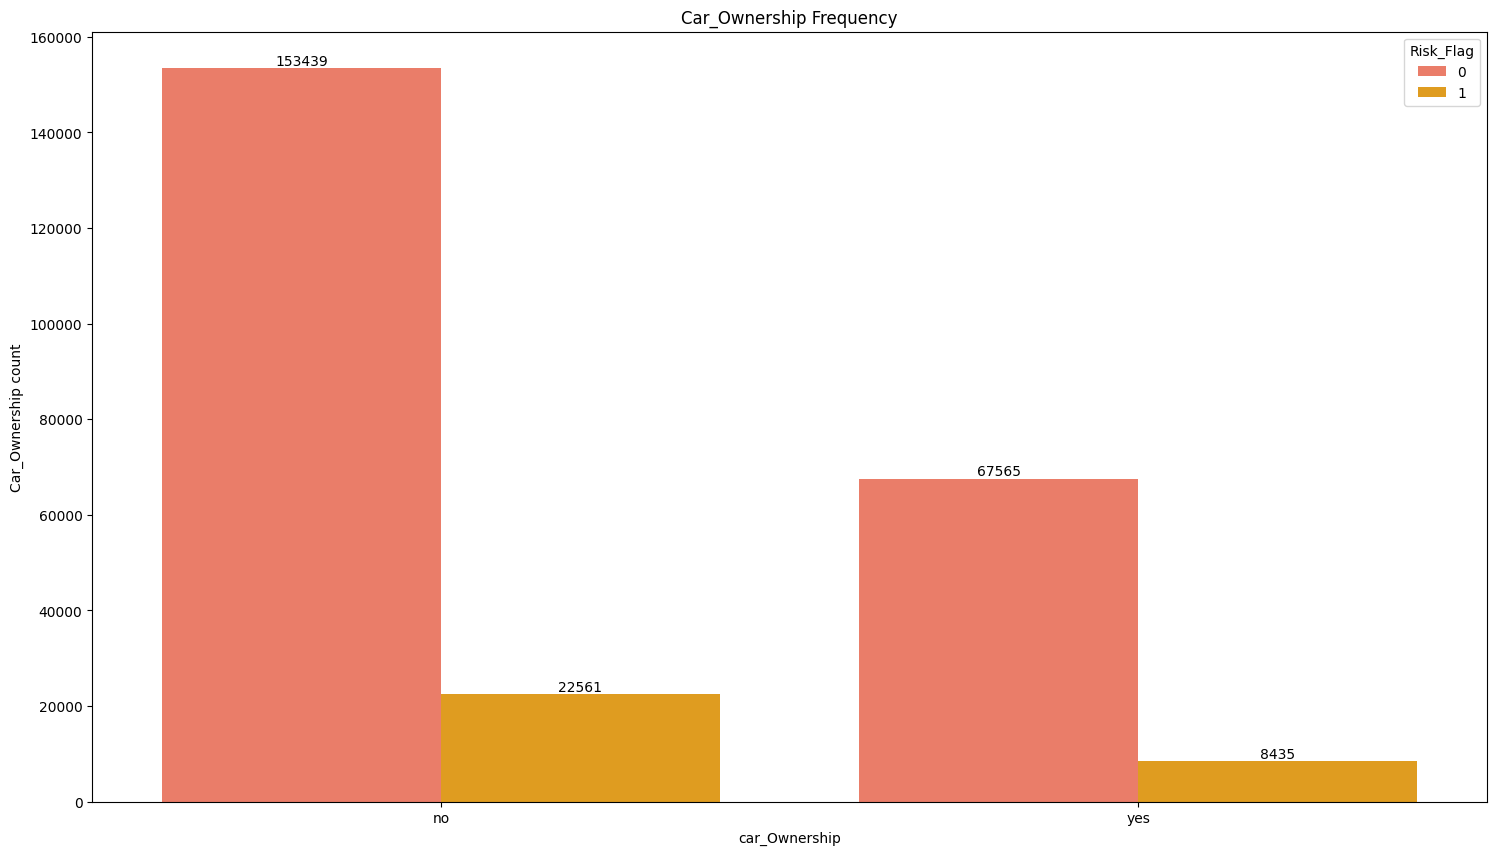

In [182]:
plt.figure(figsize=(18, 10))
ax = sns.countplot(
    x="Car_Ownership", 
    hue='Risk_Flag', 
    data=df
)

plt.title("Car_Ownership Frequency")
plt.ylabel("Car_Ownership count")
plt.xlabel("car_Ownership")

for container in ax.containers:
    ax.bar_label(container)
plt.show()

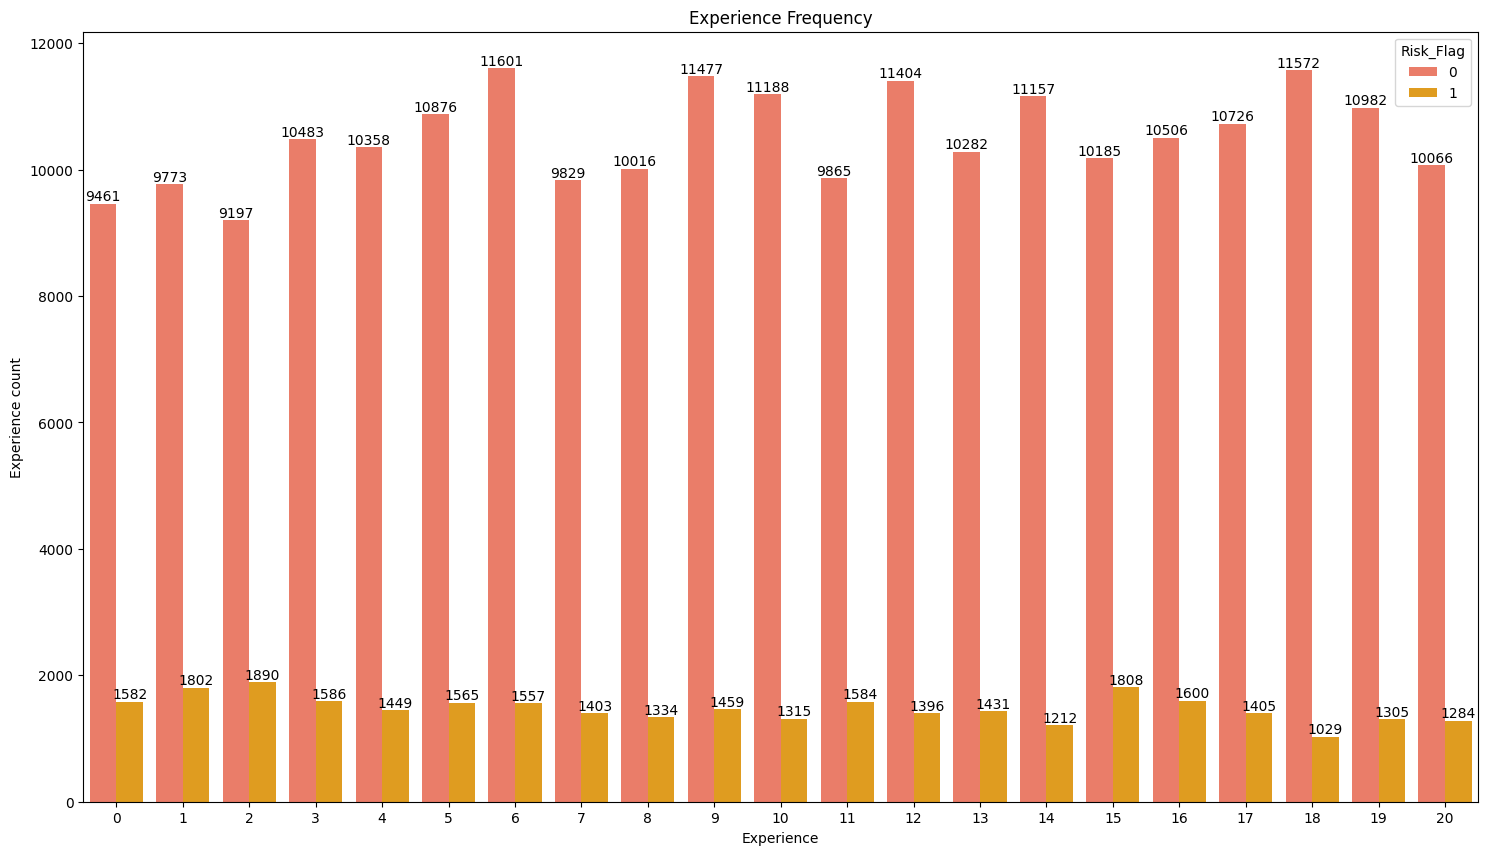

In [183]:
plt.figure(figsize=(18, 10))
ax = sns.countplot(
    x="Experience", 
    hue='Risk_Flag', 
    data=df
)

plt.title("Experience Frequency")
plt.ylabel("Experience count")
plt.xlabel("Experience")

for container in ax.containers:
    ax.bar_label(container)
plt.show()

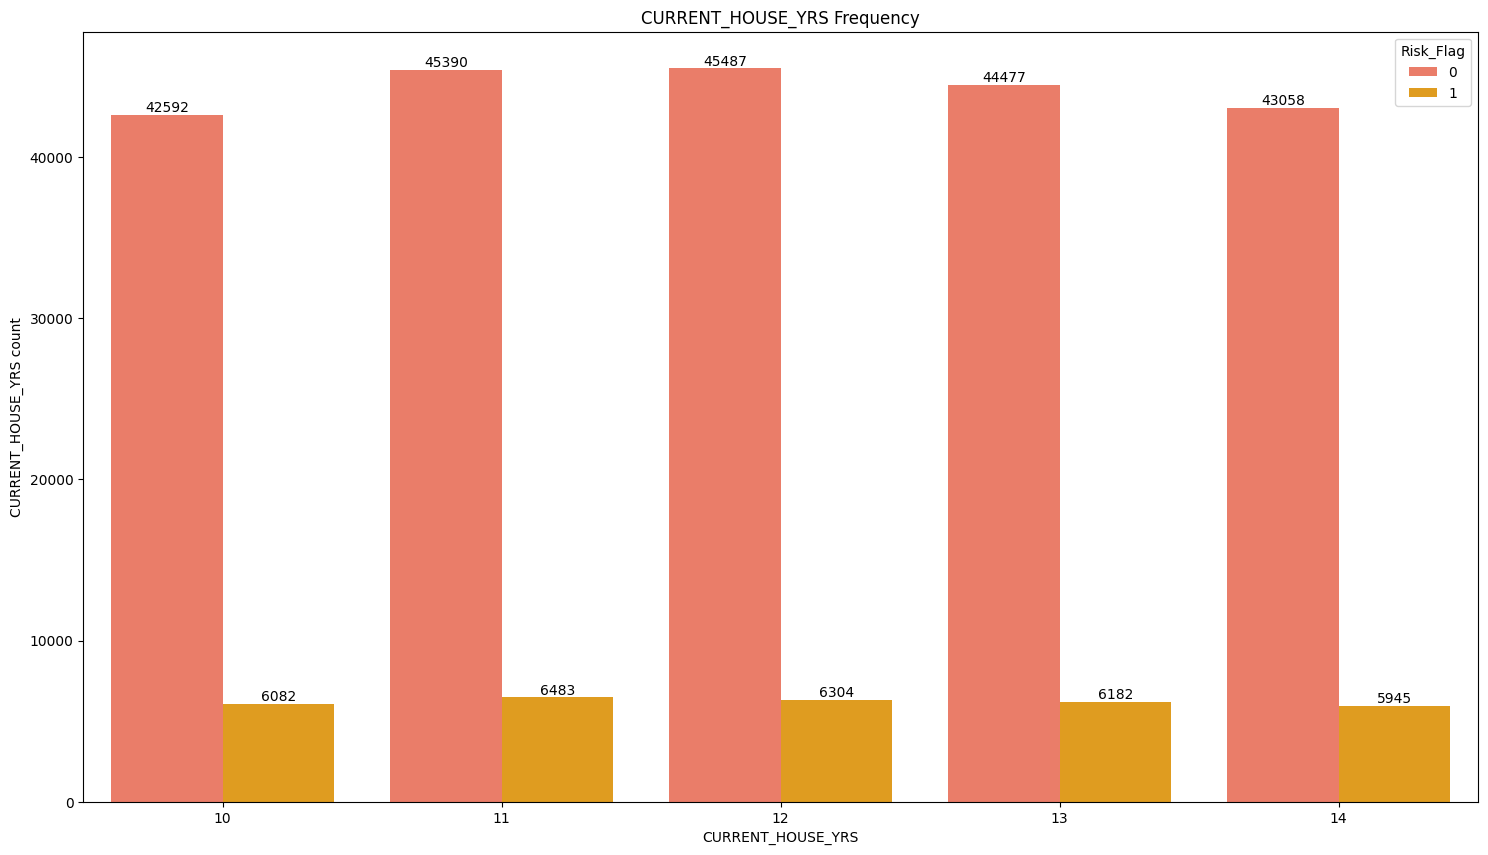

In [184]:
plt.figure(figsize=(18, 10))
ax = sns.countplot(
    x="CURRENT_HOUSE_YRS", 
    hue='Risk_Flag', 
    data=df
)

plt.title("CURRENT_HOUSE_YRS Frequency")
plt.ylabel("CURRENT_HOUSE_YRS count")
plt.xlabel("CURRENT_HOUSE_YRS")

for container in ax.containers:
    ax.bar_label(container)
plt.show()

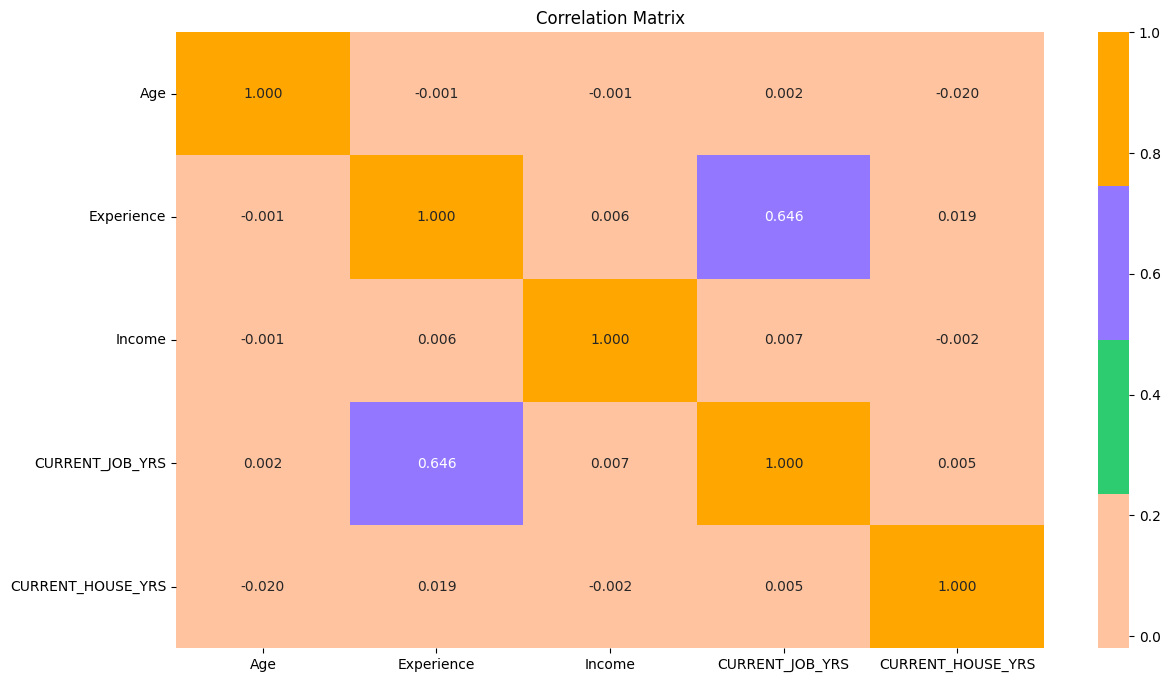

In [185]:
correlation_matrix = df[['Age', 'Experience', "Income", 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']].corr()
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt=".3f")
plt.title('Correlation Matrix')
plt.show()

In [186]:
df['Risk_Flag'].corr(df['Experience'])

-0.034522612890716876

In [187]:
df['Risk_Flag'].corr(df['CURRENT_JOB_YRS'])

-0.016941582052124867

In [188]:
df.drop(columns=['Experience'], inplace=True)

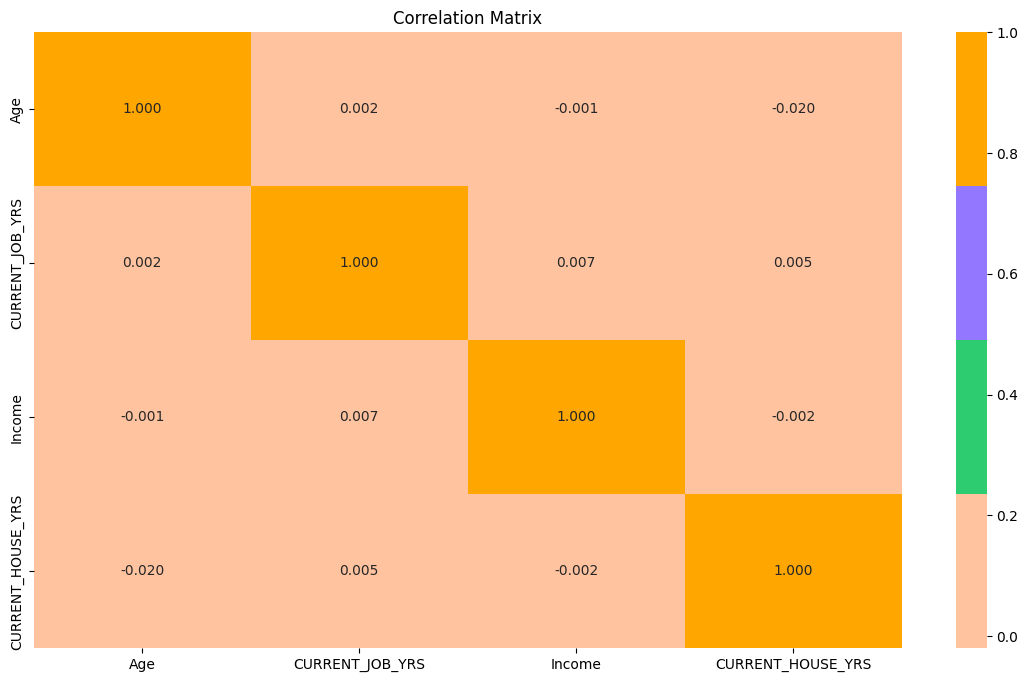

In [189]:
correlation_matrix = df[['Age', 'CURRENT_JOB_YRS', 'Income','CURRENT_HOUSE_YRS']].corr()
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt=".3f")
plt.title('Correlation Matrix')
plt.show()                

In [190]:
df.drop(columns=['CITY', 'STATE', 'Profession'], inplace=True)

In [191]:
df.sample(10)


,Income,Age,Married/Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
Id,,,,,,,,
250232,201844,61,single,rented,no,9,11,1
43218,5898669,32,married,rented,no,6,13,1
198796,2859501,61,married,rented,no,7,10,0
117050,1591827,21,single,norent_noown,no,4,12,0
15186,7731935,25,single,norent_noown,yes,3,13,0
159469,9335221,72,single,rented,no,4,10,0
27251,4958467,76,single,rented,yes,2,11,0
5386,2241112,28,single,rented,no,6,14,0
164429,6884150,69,single,rented,no,3,11,0


In [193]:
from sklearn.preprocessing import LabelEncoder

# Columns to encode
columns_to_encode = ['Married/Single', 'House_Ownership', 'Car_Ownership']

# Dictionary to hold the encoders and mappings
encoders = {}
mappings = {}

# Loop through each column and apply LabelEncoder
for column in columns_to_encode:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])
    encoders[column] = encoder
    mappings[column] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

# Print the mappings
for column, mapping in mappings.items():
    print(f'\n{column} Mapping:', mapping)


Married/Single Mapping: {'married': 0, 'single': 1}

House_Ownership Mapping: {'norent_noown': 0, 'owned': 1, 'rented': 2}

Car_Ownership Mapping: {'no': 0, 'yes': 1}


In [194]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, fbeta_score, recall_score,
precision_score, classification_report, roc_auc_score, confusion_matrix)

In [195]:
X = df.drop(['Risk_Flag'], axis=1)
y = df['Risk_Flag']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(201600, 7) (201600,)
(50400, 7) (50400,)


In [196]:
from sklearn.preprocessing import StandardScaler
# Instantiate StandardScaler as scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


from sklearn.decomposition import PCA
#Instantiate PCA 
pca = PCA()
X_train= pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Building a Baseline Model

In [197]:
# train a dummy classifier
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="uniform", random_state=42)
dummy_clf.fit(X_train, y_train)
# generate predictions
y_pred_dummy = dummy_clf.predict(X_test)

In [198]:
# derive the f2-scores & other metrics for the baseline model
f2_score_dummy = fbeta_score(y_test, y_pred_dummy, average='micro', beta=2)
print(f'F-beta score of Baseline Model: {f2_score_dummy}\n')
print('Accuracy Score of Baseline Model ➡', accuracy_score(y_test, y_pred_dummy))
print('Recall Score of Baseline Model ➡', recall_score(y_test, y_pred_dummy))
print('Precision Score of Baseline Model ➡', precision_score(y_test, y_pred_dummy))
print('F1 Score of Baseline Model ➡',f1_score(y_test, y_pred_dummy))
print('AUC Score of Baseline Model ➡', roc_auc_score(y_test, y_pred_dummy))

F-beta score of Baseline Model: 0.499265873015873

Accuracy Score of Baseline Model ➡ 0.499265873015873
Recall Score of Baseline Model ➡ 0.49298273915147606
Precision Score of Baseline Model ➡ 0.12151093439363816
F1 Score of Baseline Model ➡ 0.1949663466139271
AUC Score of Baseline Model ➡ 0.496564897323979


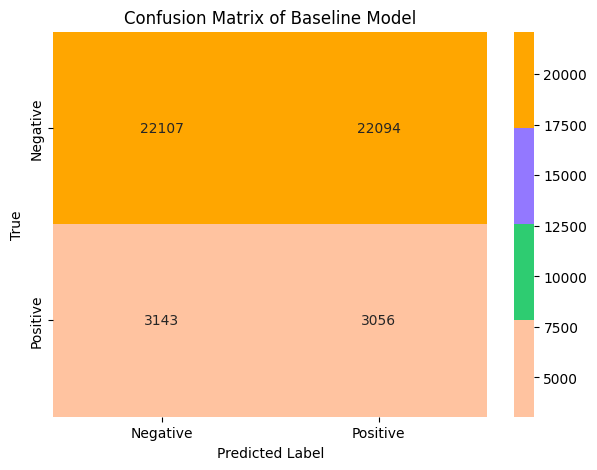

In [199]:
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_dummy), annot=True, fmt='d', cmap=cmap,
xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix of Baseline Model')
plt.xlabel('Predicted Label')
plt.ylabel('True');

Building Comparison Models

In [200]:
model = LogisticRegression(random_state=123)
model.fit(X_train, y_train)



LogisticRegression(random_state=123)

In [201]:
from sklearn.model_selection import GridSearchCV
# Define hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga'],  # Solver algorithm
    'max_iter': [100, 200],  # Maximum iterations for solver
    'tol': [1e-4, 1e-5]  # Tolerance for stopping solver
}

# Create logistic regression model and GridSearchCV
model = LogisticRegression()
grid = GridSearchCV(model, param_grid, cv=5)  # 5-fold cross-validation

# Train the model with hyperparameter tuning
grid.fit(X_train, y_train)

# Print best hyperparameters and score
print("Best Hyperparameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)

# Use the best model for prediction
best_model = grid.best_estimator_
predictions = best_model.predict(X_test)

# Evaluate model performance (e.g., accuracy) on test data
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy:", accuracy)

Best Hyperparameters: {'C': 0.001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001}
Best Cross-Validation Score: 0.876999007936508
Test Accuracy: 0.8770039682539682


In [202]:
best_params = {
    'C': 0.001, 
    'max_iter': 100,
    'penalty': 'l1', 
    'solver': 'liblinear', 
    'tol': 0.0001
}

In [203]:
logistic_clf = LogisticRegression(
    class_weight='balanced', **best_params, random_state=123).fit(X_train, y_train)

In [204]:
y_train_pred = logistic_clf.predict(X_train)

In [205]:
print(classification_report(y_train, y_train_pred))



              precision    recall  f1-score   support

           0       0.89      0.46      0.60    176803
           1       0.13      0.58      0.21     24797

    accuracy                           0.47    201600
   macro avg       0.51      0.52      0.41    201600
weighted avg       0.79      0.47      0.56    201600



In [206]:
y_test_pred = logistic_clf.predict(X_test)

In [207]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.46      0.60     44201
           1       0.13      0.59      0.22      6199

    accuracy                           0.47     50400
   macro avg       0.51      0.52      0.41     50400
weighted avg       0.80      0.47      0.56     50400



In [208]:
import xgboost as xgb

In [209]:

#from sklearn.model_selection import RandomizedSearchCV


# Define the parameter distribution
#param_dist = {
  #  'learning_rate': [0.05, 0.1, 0.2],
   # 'n_estimators': [100, 200, 500],
   # 'max_depth': [3, 5, 8],
   # 'min_child_weight': [1, 3, 5],
   # 'gamma': [0.5, 1.0, 2.0],  
   # 'colsample_bytree': [0.8, 1.0],
   # 'subsample': [0.7, 1.0]
#}

# Create XGBoost model with early stopping
#model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, 
             #             early_stopping_rounds=10, eval_metric="logloss")

# Perform randomized search
#n_iter_search = 50  # Number of parameter settings that are sampled
#random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                 #  n_iter=n_iter_search, cv=5, n_jobs=-1, random_state=42)

# Fit the model
#random_search.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=10)

# Print best hyperparameters and score
#print("Best Hyperparameters:", random_search.best_params_)
#print("Best Cross-Validation Score:", random_search.best_score_)

In [210]:


best_params = {
    'subsample': 0.7,
    'n_estimators': 500,
    'min_child_weight': 3,
    'max_depth': 8,
    'learning_rate': 0.2,
    'gamma': 2.0,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'random_state': 42,
    'scale_pos_weight': y.value_counts().values[0] / y.value_counts().values[1],
    'eval_metric': 'logloss'
}

# Create the final model with the best parameters
model = xgb.XGBClassifier(**best_params)

# Train the final model on the entire training data
model.fit(X_train, y_train)

# Evaluate the final model on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy}")

Test Set Accuracy: 0.8787698412698413


In [211]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93     44201
           1       0.50      0.80      0.62      6199

    accuracy                           0.88     50400
   macro avg       0.74      0.85      0.77     50400
weighted avg       0.91      0.88      0.89     50400



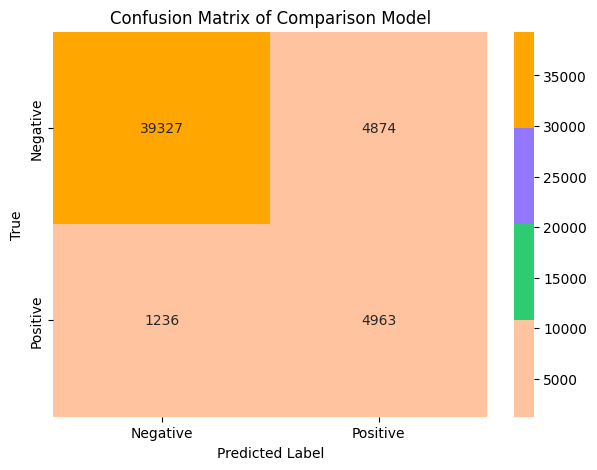

In [218]:
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap=cmap,
xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix of Comparison Model')
plt.xlabel('Predicted Label')
plt.ylabel('True');

In [213]:
#param_dist = {
  #  'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
   # 'n_estimators': [100, 200, 500, 1000],
   # 'max_depth': [3, 5, 8, 10],
   # 'min_child_weight': [1, 3, 5, 7],
    #'gamma': [0.1, 0.5, 1.0, 2.0, 5.0],
   # 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
   # 'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    #'scale_pos_weight': [y.value_counts().values[0] / y.value_counts().values[1]]
#}

# Create XGBoost model
#model = xgb.XGBClassifier(objective='binary:logistic', early_stopping_rounds=10, eval_metric="logloss", random_state=42)

# Perform randomized search
#n_iter_search = 50  # Adjust the number of parameter settings that are sampled
#random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=n_iter_search, cv=5, random_state=42)

# Fit the random search to your data
#random_search.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=10)

# Print best hyperparameters and score
#print("Best Hyperparameters:", random_search.best_params_)
#print("Best Cross-Validation Score:", random_search.best_score_)

In [214]:
best_hyperparameters = {
    'subsample': 0.8,
    'n_estimators': 200,
    'min_child_weight': 7,
    'max_depth': 10,
    'learning_rate': 0.2,
    'gamma': 0.1,
    'colsample_bytree': 0.6,
    'objective': 'binary:logistic',
    'random_state': 42,
    'scale_pos_weight': y.value_counts().values[0] / y.value_counts().values[1],
    'eval_metric': 'logloss'
}

# Create the final model with the best parameters
final_model_xgb = xgb.XGBClassifier(**best_hyperparameters)

# Train the final model on the entire training data
final_model_xgb.fit(X_train, y_train)

# Evaluate the final model on the test set
y_pred_xgb = final_model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Test Set Accuracy: {accuracy}")

Test Set Accuracy: 0.8791269841269841


In [215]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93     44201
           1       0.51      0.81      0.62      6199

    accuracy                           0.88     50400
   macro avg       0.74      0.85      0.77     50400
weighted avg       0.91      0.88      0.89     50400



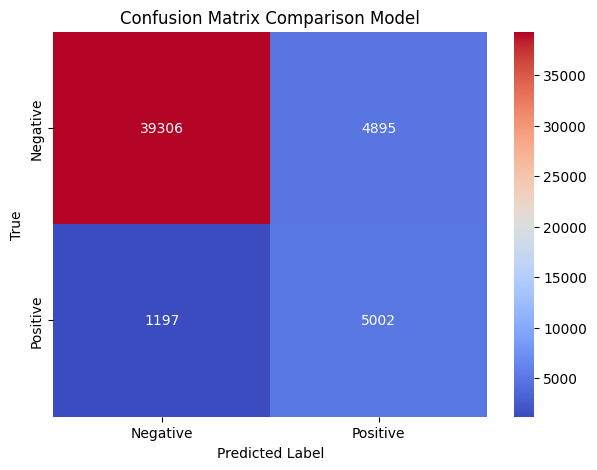

In [219]:
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='coolwarm',
xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix Comparison Model')
plt.xlabel('Predicted Label')
plt.ylabel('True');